Import Input Files and Models

In [1]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cp -r "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/3_Pipeline/2_code_3_classification_model_Yolov10-S/input" -d '/content/'

In [3]:
cp -r "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/3_Pipeline/2_code_3_classification_model_Yolov10-S/model" -d '/content/'

In [4]:
!git clone https://github.com/THU-MIG/yolov10.git

Cloning into 'yolov10'...
remote: Enumerating objects: 20329, done.
remote: Counting objects: 100% (1527/1527), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 20329 (delta 1450), reused 1363 (delta 1351), pack-reused 18802
Receiving objects: 100% (20329/20329), 11.19 MiB | 10.19 MiB/s, done.
Resolving deltas: 100% (14326/14326), done.


In [5]:
cd yolov10

/content/yolov10


In [6]:
!pip install .

Processing /content/yolov10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.meta

In [7]:
cd ..

/content


In [8]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 22.8 MB/s eta 0:00:00


In [9]:
# Modules for Detection and Displaying results
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLOv10

# Modules for Classification
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import keras_cv
from keras.optimizers import AdamW

In [10]:
# Load Image Detection Model
# object_detection_model = YOLOv10('/content/model/object_detection/object_detection_best.pt')
object_detection_model = YOLOv10('/content/model/object_detection/object_detection_roi_only.pt')

In [11]:
# Load Image Classification Model
classification_model = load_model('/content/model/image_classification/ensemble_model_best_30_epoch.keras')

# Predicting on Single Disease Image

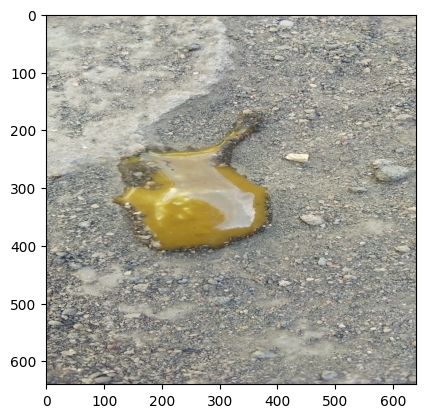

In [12]:
# Take test image - OG
HOME = os.getcwd()
file_name = 'cocci.34'
image_path = f'/content/input/{file_name}.jpg'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)


0: 640x640 1 ROI, 19.1ms
Speed: 3.9ms preprocess, 19.1ms inference, 407.2ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step


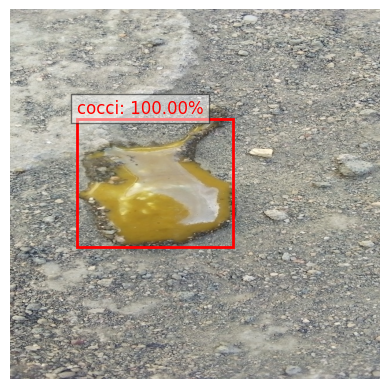

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

class_names_list = ['cocci', 'healthy', 'ncd', 'salmo']
class_colors = {
    'cocci': 'red',
    'healthy': 'blue',
    'ncd': 'green',
    'salmo': 'magenta'
}

# Predict bounding box
results = object_detection_model.predict(image_bgr)
bounding_boxes = results[0].boxes.xyxy

# Get image dimensions
image_height, image_width, _ = image_rgb.shape

fig, ax = plt.subplots(1)
# Plot image, then draw bounding boxes at the end on it
ax.imshow(image_rgb)

for box in bounding_boxes:
    # Get bounding box coordinates
    x1, y1, x2, y2 = map(int, box)

    # Ensure coordinates are within image bounds
    x1 = max(0, min(x1, image_width - 1))
    y1 = max(0, min(y1, image_height - 1))
    x2 = max(0, min(x2, image_width - 1))
    y2 = max(0, min(y2, image_height - 1))

    # Crop the RoI
    roi = image_rgb[y1:y2, x1:x2]

    if roi.size == 0:
        continue

    #========= Image Classification
    # Resize the ROI to the model input size (224x224)
    roi_resized = cv2.resize(roi, (224, 224))

    roi_resized = roi_resized / 255.0

    # Expand the dimensions to match the expected input shape (1, 224, 224, 3)
    roi_resized = np.expand_dims(roi_resized, axis=0)

    # Make a prediction
    predictions = classification_model.predict(roi_resized)

    # Calculate prediction accuracy
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names_list[predicted_class_index]
    prediction_confidence = np.max(predictions) * 100  # Confidence as a percentage

    # Draw bounding box with the corresponding class color
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2,
        edgecolor=class_colors[predicted_class_name],
        facecolor='none'
    )
    ax.add_patch(rect)

    # Draw label with the corresponding class color and confidence
    label = f"{predicted_class_name}: {prediction_confidence:.2f}%"
    plt.text(
        x1, y1 - 10, label,
        fontsize=12,
        color=class_colors[predicted_class_name],
        bbox=dict(facecolor='white', alpha=0.5)
    )

# ========Display the final result
plt.axis('off')
plt.show()


#Predicting on Multiple disease Image

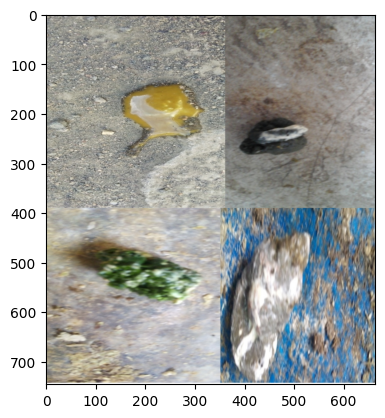

In [14]:
# Take test image - OG
HOME = os.getcwd()
file_name = 'collage'
image_path = f'/content/input/{file_name}.jpg'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)


0: 640x576 4 ROIs, 160.7ms
Speed: 5.9ms preprocess, 160.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


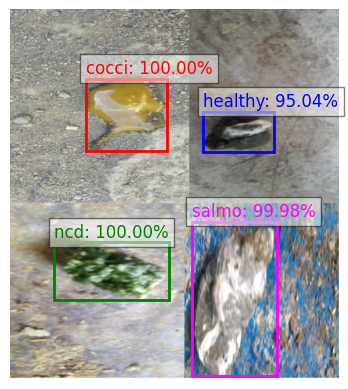

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

# Define the class names and corresponding colors
class_names_list = ['cocci', 'healthy', 'ncd', 'salmo']
class_colors = {
    'cocci': 'red',
    'healthy': 'blue',
    'ncd': 'green',
    'salmo': 'magenta'
}

# Predict bounding box
results = object_detection_model.predict(image_bgr)
bounding_boxes = results[0].boxes.xyxy

# Get image dimensions
image_height, image_width, _ = image_rgb.shape

fig, ax = plt.subplots(1)
# Plot image, then draw bounding boxes at the end on it
ax.imshow(image_rgb)

for box in bounding_boxes:
    # Get bounding box coordinates
    x1, y1, x2, y2 = map(int, box)

    # Ensure coordinates are within image bounds
    x1 = max(0, min(x1, image_width - 1))
    y1 = max(0, min(y1, image_height - 1))
    x2 = max(0, min(x2, image_width - 1))
    y2 = max(0, min(y2, image_height - 1))

    # Crop the RoI
    roi = image_rgb[y1:y2, x1:x2]

    if roi.size == 0:
        continue

    #========= Image Classification
    # Resize the ROI to the model input size (224x224)
    roi_resized = cv2.resize(roi, (224, 224))

    roi_resized = roi_resized / 255.0

    # Expand the dimensions to match the expected input shape (1, 224, 224, 3)
    roi_resized = np.expand_dims(roi_resized, axis=0)

    # Make a prediction
    predictions = classification_model.predict(roi_resized)

    # Calculate prediction accuracy
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names_list[predicted_class_index]
    prediction_confidence = np.max(predictions) * 100  # Confidence as a percentage

    # Draw bounding box with the corresponding class color
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2,
        edgecolor=class_colors[predicted_class_name],
        facecolor='none'
    )
    ax.add_patch(rect)

    # Draw label with the corresponding class color and confidence
    label = f"{predicted_class_name}: {prediction_confidence:.2f}%"
    plt.text(
        x1, y1 - 10, label,
        fontsize=12,
        color=class_colors[predicted_class_name],
        bbox=dict(facecolor='white', alpha=0.5)
    )

# ========Display the final result
plt.axis('off')
plt.show()


# Future Work - Predicting on Video sample

In [ ]:
import cv2
import matplotlib.patches as patches
import numpy as np

# Define the class names and corresponding colors
class_names_list = ['cocci', 'healthy', 'ncd', 'salmo']
class_colors = {
    'cocci': (255, 0, 0),        # Red in BGR format
    'healthy': (0, 255, 0),      # Green in BGR format
    'ncd': (0, 0, 255),          # Blue in BGR format
    'salmo': (255, 0, 255)       # Magenta in BGR format
}

# Load the video
video_path = './input/fecal_video.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
output_video_path = 'output_annotated_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Predict bounding boxes
    results = object_detection_model.predict(image_rgb)
    bounding_boxes = results[0].boxes.xyxy

    for box in bounding_boxes:
        # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, box)

        # Ensure coordinates are within image bounds
        x1 = max(0, min(x1, frame_width - 1))
        y1 = max(0, min(y1, frame_height - 1))
        x2 = max(0, min(x2, frame_width - 1))
        y2 = max(0, min(y2, frame_height - 1))

        # Crop the RoI
        roi = image_rgb[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        # Image Classification
        roi_resized = cv2.resize(roi, (224, 224))
        roi_resized = roi_resized / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=0)
        predictions = classification_model.predict(roi_resized)

        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_name = class_names_list[predicted_class_index]
        prediction_confidence = np.max(predictions) * 100  # Confidence as a percentage

        # Draw bounding box with the corresponding class color
        color = class_colors[predicted_class_name]
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Draw label with confidence
        label = f"{predicted_class_name}: {prediction_confidence:.2f}%"
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, lineType=cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Annotated video saved as {output_video_path}")



0: 384x640 1 ROI, 90.6ms
Speed: 10.7ms preprocess, 90.6ms inference, 356.6ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step

0: 384x640 1 ROI, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

0: 384x640 1 ROI, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

0: 384x640 1 ROI, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

0: 384x640 1 ROI, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

0: 384x640 1 ROI, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

0: 384x640 1 ROI, 11.4ms
Speed

In [ ]:
cp '/content/output_annotated_video.mp4' "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/3_Pipeline/2_code_3_classification_model_Yolov10-S/video_output"